Import packages

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score, log_loss
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/5525/')

Mounted at /content/drive


In [ ]:
def convert_code_to_float(code):
  if pd.isna(code):
    return np.nan

  str_code = str(code).strip().upper()

  if str_code.startswith('E'):
    num = str_code[1:].split('.')[0]
    if num.isdigit():
      return np.float32(num) + 1000

  if str_code.startswith('V'):
    num = str_code[1:].split('.')[0]
    if num.isdigit():
      return np.float32(num) + 2000

  else:
    num = str_code.split('.', 1)
    if num[0].isdigit():
      return np.float32(num[0])

  return np.nan

In [ ]:
ranges = [
    (1, 139, 'Infectious Diseases'),
    (140, 239, 'Neoplasms'),
    (240, 279, 'Endocrine Disorders'),
    (280, 289, 'Blood Diseases'),
    (290, 319, 'Mental Disorders'),
    (320, 389, 'Nervous System'),
    (390, 459, 'Circulatory'),
    (460, 519, 'Respiratory'),
    (520, 579, 'Digestive'),
    (580, 629, 'Genitourinary'),
    (630, 679, 'Pregnancy'),
    (680, 709, 'Skin'),
    (710, 739, 'Musculoskeletal'),
    (740, 759, 'Congenital'),
    (760, 779, 'Perinatal'),
    (780, 799, 'Symptoms'),
    (800, 999, 'Injury/Poisoning'),
    (2000, 2099, 'Supplementary'),
    (1000, 1999, 'External Cause'),
]

def icd9_map(code):
  for lower, upper, cate in ranges:
    if lower <= code <= upper:
      return cate
  return np.nan



Preprocess datasets

In [ ]:
data = pd.read_csv('diabetic_data.csv')
data.replace('?', np.nan, inplace=True) #Replace ? with NaN
data.drop(columns=['patient_nbr', 'encounter_id', 'weight'], inplace=True) #Drop patient_nbr, encounter_id, weight columns
data.drop(data[data['discharge_disposition_id'].isin([11, 19, 20, 21])].index, inplace=True) #Drop patients who died

ages = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
        '[50-60)': 55, '[60-70)': 65, '[70-80)': 76, '[80-90)': 85, '[90-100)': 95}
data.replace({'age': ages}, inplace=True) #Convert age to a single digit instead of a range.
data.drop(data[data['gender'] == 'Unknown/Invalid'].index, inplace=True) #Drop the 3 unknown rows
data.replace({'change': {'No': 0, 'Ch': 1}}, inplace=True) #Convert change to an integer.
data.replace({'diabetesMed': {'No': 0, 'Yes': 1}}, inplace=True) #Convert diabetesMed to an integer.
data.replace({'readmitted': {'NO': 0, '<30': 1, '>30': 0}}, inplace=True) #Convert readmitted to an integer.
data.replace({'max_glu_serum': {np.nan: 0, 'Norm': 1, '>200': 2, '>300': 3}}, inplace=True) #Convert max_glu_serum to an integer
data.replace({'A1Cresult': {np.nan: 0, 'Norm': 1, '>7': 2, '>8': 3}}, inplace=True) #Convert A1Cresult to an integer

#Diag clean-up
for col in ['diag_1', 'diag_2', 'diag_3']:
  data[col] = data[col].apply(convert_code_to_float)
  #data[col] = data[col].apply(icd9_map) higher AUC without this

cols = ['gender', 'race', 'payer_code', 'medical_specialty', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for col in cols:
  data[col] = data[col].fillna('Unknown')

data = pd.get_dummies(data, columns=cols, drop_first=True, dummy_na=False) #One-hot encode the categorical columns

prescriptions = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'] #List of prescription names
usage = {'No': 0, 'Up': 1, 'Down': 2, 'Steady': 3} #Convert prescription values to integers
for prescription in prescriptions:
  data.replace({prescription: usage}, inplace=True)

<ipython-input-102-381bde4a454f>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'age': ages}, inplace=True) #Convert age to a single digit instead of a range.
<ipython-input-102-381bde4a454f>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'change': {'No': 0, 'Ch': 1}}, inplace=True) #Convert change to an integer.
<ipython-input-102-381bde4a454f>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `re

Find important features.

In [ ]:
print(data.corrwith(data['readmitted']).abs().sort_values(ascending=False))

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


readmitted                            1.000000
number_inpatient                      0.167585
discharge_disposition_id_22           0.073532
number_emergency                      0.060785
number_diagnoses                      0.052337
                                        ...   
admission_type_id_2                   0.000133
medical_specialty_Emergency/Trauma    0.000115
payer_code_MP                         0.000043
examide                                    NaN
citoglipton                                NaN
Length: 180, dtype: float64


Drop unimportant columns.

In [ ]:
data.drop(columns=['examide', 'citoglipton'], inplace=True) #Drop the empty prescription columns

Finalize the preprocessed dataset.

In [ ]:
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True) #Drop any rows with missing values
data.reset_index(drop=True, inplace=True)

Prepare data and convert into tensors and loaders.

In [ ]:
X = data.drop(columns=['readmitted']).values
Y = data['readmitted'].values

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

Check the balance of the readmitted class.

In [ ]:
count = np.bincount(Ytrain)
print(f'Class 0: {count[0]}')
print(f'Class 1: {count[1]}')

Class 0: 69891
Class 1: 8981


Use SMOTE to balance the readmitted class so that the models dont prefer the most common class instead of learning the features.

In [ ]:
#Dont use since the class weights are balanced in the models
#from imblearn.over_sampling import SMOTE
#Xtrain, Ytrain = SMOTE().fit_resample(Xtrain, Ytrain)

Check the balance of the readmitted class after balancing.

In [ ]:
count = np.bincount(Ytrain)
print(f'Class 0: {count[0]}')
print(f'Class 1: {count[1]}')

Class 0: 69891
Class 1: 8981


Create tensors for the data.

In [ ]:
XtrainTensor = torch.tensor(Xtrain, dtype=torch.float32)
YtrainTensor = torch.tensor(Ytrain, dtype=torch.long)
XtestTensor = torch.tensor(Xtest, dtype=torch.float32)
YtestTensor = torch.tensor(Ytest, dtype=torch.long)

trainDataset = TensorDataset(XtrainTensor, YtrainTensor)
trainLoader = DataLoader(trainDataset, batch_size = 64, shuffle=True)
testDataset = TensorDataset(XtestTensor, YtestTensor)
testLoader = DataLoader(testDataset, batch_size = 64)

Logistic regression to predict readmission of a diabetic patient.

In [ ]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(Xtrain, Ytrain)
prediction = logistic.predict(Xtest)
logistic_result = {}

logistic_result['accuracy'] = accuracy_score(Ytest, prediction)
logistic_result['auc'] = roc_auc_score(Ytest, prediction)
logistic_result['recall'] = recall_score(Ytest, prediction)
logistic_result['confusion_matrix'] = confusion_matrix(Ytest, prediction)
display(logistic_result)

{'accuracy': 0.6744256808154572,
 'auc': np.float64(0.6159025914247216),
 'recall': 0.5398854120758043,
 'confusion_matrix': array([[12074,  5376],
        [ 1044,  1225]])}

In [ ]:
features = pd.DataFrame({
    'coefficient': logistic.coef_[0],
    'sort': np.abs(logistic.coef_[0])
}, index=data.drop(columns=['readmitted']).columns)
features.sort_values(by='sort', ascending=False, inplace=True)
features.drop(columns=['sort'], inplace=True)
display(features.head(10))

,coefficient
number_inpatient,0.358489
discharge_disposition_id_22,0.190960
discharge_disposition_id_3,0.156484
payer_code_Unknown,0.114953
medical_specialty_Gynecology,-0.113043
discharge_disposition_id_5,0.111317
medical_specialty_Pediatrics-Endocrinology,-0.100928
diabetesMed,0.096208
discharge_disposition_id_2,0.092068
tolbutamide,-0.084718


Random forest to predict readmission of a diabetic patient.

In [ ]:
forest = RandomForestClassifier(class_weight='balanced')
trees = {'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 5]}
grid = GridSearchCV(forest, trees, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid.fit(Xtrain, Ytrain)
best_model = grid.best_estimator_
prediction = best_model.predict(Xtest)

random_forest_result = {}
random_forest_result['best_n_estimators'] = best_model.n_estimators
random_forest_result['best_max_depth'] = best_model.max_depth
random_forest_result['best_min_samples_leaf'] = best_model.min_samples_leaf
random_forest_result['accuracy'] = accuracy_score(Ytest, prediction)
random_forest_result['auc'] = roc_auc_score(Ytest, prediction)
random_forest_result['recall'] = recall_score(Ytest, prediction)
random_forest_result['confusion_matrix'] = confusion_matrix(Ytest, prediction)

display(random_forest_result)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'best_n_estimators': 200,
 'best_max_depth': 10,
 'best_min_samples_leaf': 5,
 'accuracy': 0.6884223337897459,
 'auc': np.float64(0.617484533660992),
 'recall': 0.5253415601586602,
 'confusion_matrix': array([[12383,  5067],
        [ 1077,  1192]])}

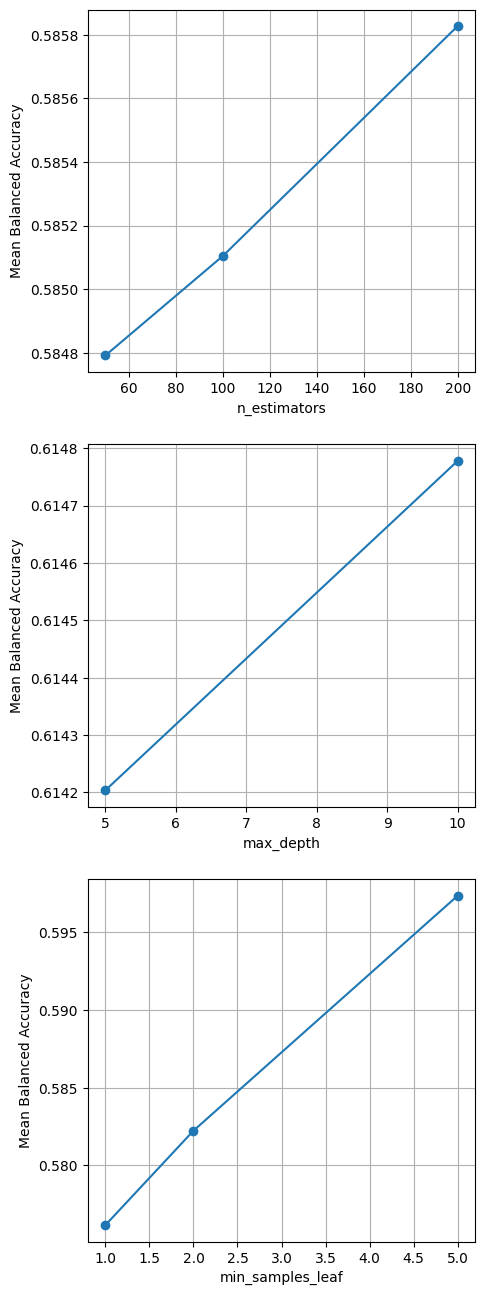

In [ ]:
cv_results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(5, 16))

plt.subplot(3, 1, 1)
cv_results.groupby('param_n_estimators')['mean_test_score'].mean().plot(marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Balanced Accuracy')
plt.grid(True)

plt.subplot(3, 1, 2)
cv_results.groupby('param_max_depth')['mean_test_score'].mean().plot(marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean Balanced Accuracy')
plt.grid(True)

plt.subplot(3, 1, 3)
cv_results.groupby('param_min_samples_leaf')['mean_test_score'].mean().plot(marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Balanced Accuracy')
plt.grid(True)

plt.show()

Network to predict readmission of a diabetic patient.

In [ ]:
class ReadmissionNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size

        # Layer 1
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.1)

        self.out = nn.Linear(32, 2)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.dropout1(F.gelu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.gelu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.gelu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.gelu(self.bn4(self.fc4(x))))
        return F.log_softmax(self.out(x), dim=1)

def train(model, loader, optimizer, lossfn):
  model.train()
  totalLoss = 0
  totalCorrect = 0
  for inputs, labels in loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = lossfn(outputs, labels)
    loss.backward()
    optimizer.step()
    totalLoss += loss.item()
    totalCorrect += outputs.argmax(dim=1).eq(labels).sum().item()
  return totalLoss / len(loader), totalCorrect / len(loader.dataset)

def test(model, loader):
  model.eval()
  pred = []
  true = []
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred.extend(outputs.argmax(dim=1).tolist())
      true.extend(labels.tolist())
  return accuracy_score(true, pred), roc_auc_score(true, pred), recall_score(true, pred), confusion_matrix(true, pred)

In [ ]:
model = ReadmissionNetwork(X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(Ytrain), y=Ytrain), dtype=torch.float32)
#weights *= torch.tensor([0.9, 1.2], dtype = torch.float32)
lossfn = nn.CrossEntropyLoss(weight=weights)

nn_result = {}

for epoch in range(25):
  loss, trainAccuracy = train(model, trainLoader, optimizer, lossfn)
  testAccuracy, AUC, recall, confusion = test(model, testLoader)
  nn_result[epoch] = {'loss': loss, 'trainAccuracy': trainAccuracy, 'testAccuracy': testAccuracy, 'AUC': AUC, 'recall': recall, 'confusion': confusion}

display(nn_result)

{0: {'loss': 0.6906902893519653,
  'trainAccuracy': 0.6521579267674207,
  'testAccuracy': 0.6700136923779096,
  'AUC': np.float64(0.5965394421636584),
  'recall': 0.50110180696342,
  'confusion': array([[12075,  5375],
         [ 1132,  1137]])},
 1: {'loss': 0.6660692017202153,
  'trainAccuracy': 0.651143625114109,
  'testAccuracy': 0.654546376591105,
  'AUC': np.float64(0.6119554074412696),
  'recall': 0.5566328779197884,
  'confusion': array([[11644,  5806],
         [ 1006,  1263]])},
 2: {'loss': 0.6576112463574824,
  'trainAccuracy': 0.6613119991885587,
  'testAccuracy': 0.6798012069577565,
  'AUC': np.float64(0.6137637220744026),
  'recall': 0.5279858968708683,
  'confusion': array([[12207,  5243],
         [ 1071,  1198]])},
 3: {'loss': 0.6536048098443875,
  'trainAccuracy': 0.6703012475910336,
  'testAccuracy': 0.6916172219686597,
  'AUC': np.float64(0.615838945498124),
  'recall': 0.5174085500220361,
  'confusion': array([[12464,  4986],
         [ 1095,  1174]])},
 4: {'los

In [ ]:
algo_resutls = {'logistic': logistic_result, 'random_forest': random_forest_result}
algo_results = pd.DataFrame(algo_resutls)
algo_results

,logistic,random_forest
accuracy,0.674426,0.688422
auc,0.615903,0.617485
recall,0.539885,0.525342
confusion_matrix,"[[12074, 5376], [1044, 1225]]","[[12383, 5067], [1077, 1192]]"
best_n_estimators,NaN,200
best_max_depth,NaN,10
best_min_samples_leaf,NaN,5


In [ ]:
nn_results = pd.DataFrame(nn_result).T
nn_results.index = "Epoch " + nn_results.index.astype(str)
display(nn_results)

,loss,trainAccuracy,testAccuracy,AUC,recall,confusion
Epoch 0,0.69069,0.652158,0.670014,0.596539,0.501102,"[[12075, 5375], [1132, 1137]]"
Epoch 1,0.666069,0.651144,0.654546,0.611955,0.556633,"[[11644, 5806], [1006, 1263]]"
Epoch 2,0.657611,0.661312,0.679801,0.613764,0.527986,"[[12207, 5243], [1071, 1198]]"
Epoch 3,0.653605,0.670301,0.691617,0.615839,0.517409,"[[12464, 4986], [1095, 1174]]"
Epoch 4,0.64971,0.665547,0.658299,0.618293,0.566329,"[[11696, 5754], [984, 1285]]"
Epoch 5,0.648403,0.668247,0.663725,0.620401,0.564125,"[[11808, 5642], [989, 1280]]"
Epoch 6,0.645055,0.665876,0.690502,0.621727,0.532393,"[[12408, 5042], [1061, 1208]]"
Epoch 7,0.643768,0.665242,0.681576,0.621668,0.543852,"[[12206, 5244], [1035, 1234]]"
Epoch 8,0.643506,0.665559,0.655459,0.618798,0.571177,"[[11629, 5821], [973, 1296]]"
Epoch 9,0.640445,0.668133,0.689082,0.621499,0.533715,"[[12377, 5073], [1058, 1211]]"


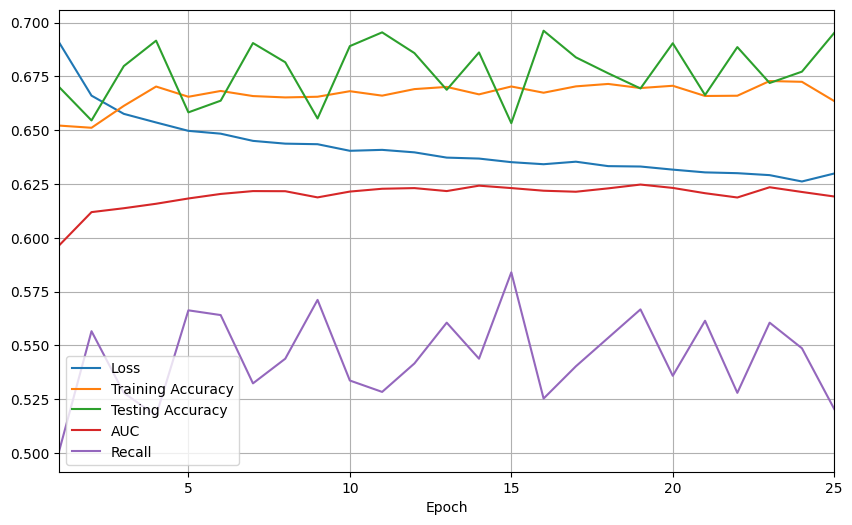

In [ ]:
nn_results = pd.DataFrame(nn_result).T
nn_results.index = nn_results.index + 1
plt.figure(figsize=(10, 6))
plt.gca().set_xlim(1, 25)
plt.plot(nn_results['loss'], label='Loss')
plt.plot(nn_results['trainAccuracy'], label='Training Accuracy')
plt.plot(nn_results['testAccuracy'], label='Testing Accuracy')
plt.plot(nn_results['AUC'], label='AUC')
plt.plot(nn_results['recall'], label='Recall')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
